In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import os
import glob
import json
import csv
import sys
import numpy as np
import math
import functools
from tqdm import tqdm
import seaborn as sns

In [2]:
!ls /hot/data/flights/*.csv | head

/hot/data/flights/flights_on_time_performance_2009_01.csv
/hot/data/flights/flights_on_time_performance_2009_02.csv
/hot/data/flights/flights_on_time_performance_2009_03.csv
/hot/data/flights/flights_on_time_performance_2009_04.csv
/hot/data/flights/flights_on_time_performance_2009_05.csv
/hot/data/flights/flights_on_time_performance_2009_06.csv
/hot/data/flights/flights_on_time_performance_2009_07.csv
/hot/data/flights/flights_on_time_performance_2009_08.csv
/hot/data/flights/flights_on_time_performance_2009_09.csv
/hot/data/flights/flights_on_time_performance_2009_10.csv


In [3]:
df = pd.read_csv('/hot/data/flights/flights_on_time_performance_2009_01.csv', nrows=10)
cleaned_columns = list(map(lambda x: x.lower(), list(df.columns)))

In [4]:
df.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,...,DIV4_TAIL_NUM,DIV5_AIRPORT,DIV5_AIRPORT_ID,DIV5_AIRPORT_SEQ_ID,DIV5_WHEELS_ON,DIV5_TOTAL_GTIME,DIV5_LONGEST_GTIME,DIV5_WHEELS_OFF,DIV5_TAIL_NUM,Unnamed: 109
0,2009,1,1,18,7,2009-01-18,9E,20363,9E,87099E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2009,1,1,19,1,2009-01-19,9E,20363,9E,87459E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2009,1,1,20,2,2009-01-20,9E,20363,9E,89249E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2009,1,1,21,3,2009-01-21,9E,20363,9E,80259E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2009,1,1,22,4,2009-01-22,9E,20363,9E,89239E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
output_columns = ['CarrierName', 'CarrierCode', 'FlightNumber',
                               'Day', 'Month', 'Year', 'DayOfWeek',
                               'OriginCity', 'OriginState', 'OriginAirportIATACode', 'OriginLongitude', 'OriginLatitude',
                               'OriginAltitude',
                               'DestCity', 'DestState', 'DestAirportIATACode', 'DestLongitude', 'DestLatitude', 'DestAltitude',
                               'Distance',
                               'CancellationReason', 'Cancelled', 'Diverted', 'CrsArrTime', 'CrsDepTime',
                               'ActualElapsedTime', 'AirTime', 'ArrDelay',
                               'CarrierDelay', 'CrsElapsedTime',
                               'DepDelay', 'LateAircraftDelay', 'NasDelay',
                               'SecurityDelay', 'TaxiIn', 'TaxiOut', 'WeatherDelay',
                               'AirlineYearFounded', 'AirlineYearDefunct']

In [6]:
Sfinal = set(map(lambda x: x.lower(), output_columns))

In [7]:
Sinput = set(map(lambda x: x.replace('_', ''), cleaned_columns))

In [8]:
csvinput_cols = Sinput & Sfinal

In [9]:
# indices
csvinput_cols

{'actualelapsedtime',
 'airtime',
 'arrdelay',
 'cancelled',
 'carrierdelay',
 'crsarrtime',
 'crsdeptime',
 'crselapsedtime',
 'dayofweek',
 'depdelay',
 'distance',
 'diverted',
 'lateaircraftdelay',
 'month',
 'nasdelay',
 'securitydelay',
 'taxiin',
 'taxiout',
 'weatherdelay',
 'year'}

In [10]:
normalcols = [name.replace('_', '') for name in cleaned_columns]

In [11]:
relevant_column_pairs = sorted([(name, normalcols.index(name)) for name in csvinput_cols], key=lambda x: x[1])

In [12]:
relevant_columns = [t[0] for t in relevant_column_pairs]
relevant_indices = [t[1] for t in relevant_column_pairs]
relevant_columns, relevant_indices

(['year',
  'month',
  'dayofweek',
  'crsdeptime',
  'depdelay',
  'taxiout',
  'taxiin',
  'crsarrtime',
  'arrdelay',
  'cancelled',
  'diverted',
  'crselapsedtime',
  'actualelapsedtime',
  'airtime',
  'distance',
  'carrierdelay',
  'weatherdelay',
  'nasdelay',
  'securitydelay',
  'lateaircraftdelay'],
 [0, 2, 4, 29, 31, 36, 39, 40, 42, 47, 49, 50, 51, 52, 54, 56, 57, 58, 59, 60])

In [13]:
# should parse delayed? --> do so if representation is SMALLER than smallest optimized representation that's possible.
# for each column compute statistics

# needs df, df_str
def get_stats(df, df_str):
    stats = []
    for c in df.columns:
        stat = {'name' : c, 'type': str(df[c].dtype)}

        null_count = df[c].isna().count()
        stat['nullable'] = null_count > 0
        stat['nrows'] = len(df[c])
        stat['nnulls'] = null_count
        stat['cardinality'] = len(df[c].unique())

        # csv data from str dataframe!
        stat['csvcellmin'] = df_str[c].str.len().min()
        stat['csvcellmax'] = df_str[c].str.len().max()

        if stat['type'] == 'int64':
            # check min/max
            stat['imin'] = int(df[c].min())
            stat['imax'] = int(df[c].max())

        if stat['type'] == 'float64':
            stat['fmin'] = df[c].min()
            stat['fmax'] = df[c].max()

        stats.append(stat)
    return pd.DataFrame(stats)


In [14]:
optimization_list = ['null_value_optimization', 'i8_range_compression',
                     'i16_range_compression',
                     'i24_range_compression',
                     'i32_range_compression',
                    'range_compression_optimization',
                    'delay_parsing',
                     'constant_encoding',
                    'dict_singlebyte_encoding',
                    'dict_twobyte_encoding',
                    'dict_encoding']

# now for each column, decide which optimization is possible!
def determine_col_optimizations(row, threshold=0.05):
    # NVO?
    # null values form more than 95% of all rows or less than 5% of all optimizations
    null_ratio = row['nnulls'] / row['nrows']
    null_optimization = null_ratio <= threshold or null_ratio >= 1.0 - threshold
    
    opts = {'null_value_optimization' : null_optimization}
    
    # integer range squeeze?
    if not math.isnan(row['imin']) and not math.isnan(row['imax']):
        imax_range = int(row['imax']) - int(row['imin'])
    
        # can we compress to 4 bytes, 2 bytes, 1 byte?
        if imax_range < 2**8:
            opts['i8_range_compression'] = True
        if imax_range < 2**16:
            opts['i16_range_compression'] = True
        if imax_range < 2**24:
            opts['i24_range_compression'] = True
        if imax_range < 2**32:
            opts['i32_range_compression'] = True
            opts['range_compression_optimization'] = True
            
    # check whether cell size is < 7 bytes -> delay parsing!
    # use 7 here to reserve 1 byte for length/flags
    csv_max_cell_size = row['csvcellmax'] - row['csvcellmin'] + 1
    opts['delay_parsing'] = csv_max_cell_size <= 7
        
    # dictionary encoding
    card = row['cardinality']
    max_dict_size = 128000
    if card < 2**8:
        opts['dict_singlebyte_encoding'] = True
    if card < 2**16:
        opts['dict_twobyte_encoding'] = True
    if card <= max_dict_size:
        opts['dict_encoding'] = True
    opts['constant_encoding'] = card == 1
    
    #raise Exception()
    return opts
    

In [15]:
# function to determine how many columns can do each optimization (no details, simple analysis)
def detect_file_specific_optimizations(path, relevant_indices=None, threshold=0.05):
    df = pd.read_csv(path, usecols=relevant_indices, low_memory=False)
    df_str = pd.read_csv(path, dtype=str, usecols=relevant_indices, low_memory=False)
    
    df_stats = get_stats(df, df_str)
    df_stats['optimizations'] = df_stats.apply(functools.partial(determine_col_optimizations), axis=1)
    
    # for each column count how many of each optimizations are available
    df_this_file_opt = pd.DataFrame(list(df_stats['optimizations'].values))
    row = df_this_file_opt.sum().to_dict()
    row['path'] = path
    row['ncolumns'] = len(df.columns)
    
    
    # add optimization details
    # convert df_stats into detailed overview
    details = df_stats.set_index('name').to_dict('index')

    for k in details.keys():
        # make optimizations flat list
        L = []
        for kk, vv in details[k]['optimizations'].items():
            if vv:
                L.append(kk)
        L = sorted(L)
        details[k]['optimizations'] = L
    row['details'] = details
    
    
    
    # general query properties per file
    
    
    # 1. filter query-selectivity (??)
    # in flights the only
#     query_sel = 0.0
#     row['query_sel'] = query_sel
    
    # 2. join query-selectivity (??)

    return row

In [16]:
path = '/hot/data/flights/flights_on_time_performance_2009_01.csv'
row = detect_file_specific_optimizations(path)

In [17]:
# run detection over all files (this might take a while!!!)
paths = glob.glob('/hot/data/flights/flights_on_time_performance_*.csv')

In [77]:
#Import package
from joblib import Parallel, delayed
from joblib import Memory
import time

start = time.time()
results = Parallel(n_jobs=32, verbose=10)(
    delayed(detect_file_specific_optimizations)(path, relevant_indices) for path in paths)
stop = time.time()

print('Elapsed time for the entire processing: {:.2f} s'
      .format(stop - start))

[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   8 tasks      | elapsed:   24.6s
[Parallel(n_jobs=32)]: Done  21 tasks      | elapsed:   28.0s
[Parallel(n_jobs=32)]: Done  34 tasks      | elapsed:   44.8s
[Parallel(n_jobs=32)]: Done  49 tasks      | elapsed:   49.6s
[Parallel(n_jobs=32)]: Done  64 tasks      | elapsed:  1.1min
[Parallel(n_jobs=32)]: Done  83 out of 132 | elapsed:  1.3min remaining:   44.4s
[Parallel(n_jobs=32)]: Done  97 out of 132 | elapsed:  1.5min remaining:   32.7s
[Parallel(n_jobs=32)]: Done 111 out of 132 | elapsed:  1.6min remaining:   18.4s
[Parallel(n_jobs=32)]: Done 125 out of 132 | elapsed:  1.7min remaining:    5.8s


Elapsed time for the entire processing: 119.29 s


[Parallel(n_jobs=32)]: Done 132 out of 132 | elapsed:  2.0min finished


In [18]:
rows = results

NameError: name 'results' is not defined

In [79]:
# rows = []
# for path in tqdm(paths):
#     row = detect_file_specific_optimizations(path, relevant_indices)
#     rows.append(row)

In [80]:
df_all = pd.DataFrame(rows)

In [19]:
#df_all.to_csv('flights_original_optimizations.csv', index=None)
df_all = pd.read_csv('flights_original_optimizations.csv')

In [20]:
df_all.head(1)

,null_value_optimization,i8_range_compression,i16_range_compression,i24_range_compression,i32_range_compression,range_compression_optimization,delay_parsing,dict_singlebyte_encoding,dict_twobyte_encoding,dict_encoding,constant_encoding,path,ncolumns,details
0,20,3,5,5,5,5,20,8,20,20,2,/hot/data/flights/flights_on_time_performance_...,20,"{'YEAR': {'type': 'int64', 'nullable': True, '..."


In [ ]:
row

In [21]:
df_opt = df_all.copy()

In [22]:
# what are all the columns for each optimization? Do they differ between files?
# if not, then stable behavior across files!
# => bad for hyperspecialization...
opt_dict = {name : [] for name in optimization_list}
# accumulate columns for which this optimization holds
for idx, row in df_opt.iterrows():
    for k, v in row['details'].items():
        for name in v['optimizations']:
            opt_dict[name].append(k)

opt_dict = {k : sorted(list(set(v))) for k, v in opt_dict.items()}
#df_col_overview = pd.DataFrame(opt_dict)
pd.DataFrame([{'name' : k, 'noptimizations' : len(v), 'optimizations' : v} for k,v in opt_dict.items()])

AttributeError: 'str' object has no attribute 'items'

In [23]:
optimization_list

['null_value_optimization',
 'i8_range_compression',
 'i16_range_compression',
 'i24_range_compression',
 'i32_range_compression',
 'range_compression_optimization',
 'delay_parsing',
 'constant_encoding',
 'dict_singlebyte_encoding',
 'dict_twobyte_encoding',
 'dict_encoding']

Plot figure out of specialization across files

In [24]:
df_opt = df_opt.sort_values(by='path').reset_index(drop=True)

In [25]:
# plot how many files could have optimizations!
#name = os.path.basename(path)

names = ['FULLY SPECIALIZED'] + list(df_opt.path.apply(os.path.basename).values)
n_names = len(names)

n_opts = len(optimization_list)

count_matrix = np.zeros((n_names, n_opts)) * np.nan
n_columns = df_opt.iloc[0]['ncolumns']


# fill in first row with ncolumns
count_matrix[0, :] = n_columns

# fill in from rows
for idx, row in df_opt.iterrows():
    row = row.to_dict()
    for key, value in row.items():
        if key in optimization_list:
            j = optimization_list.index(key)
            count_matrix[idx + 1, j] = value
count_matrix.shape

(133, 11)

In [26]:
sns.set_context('poster')

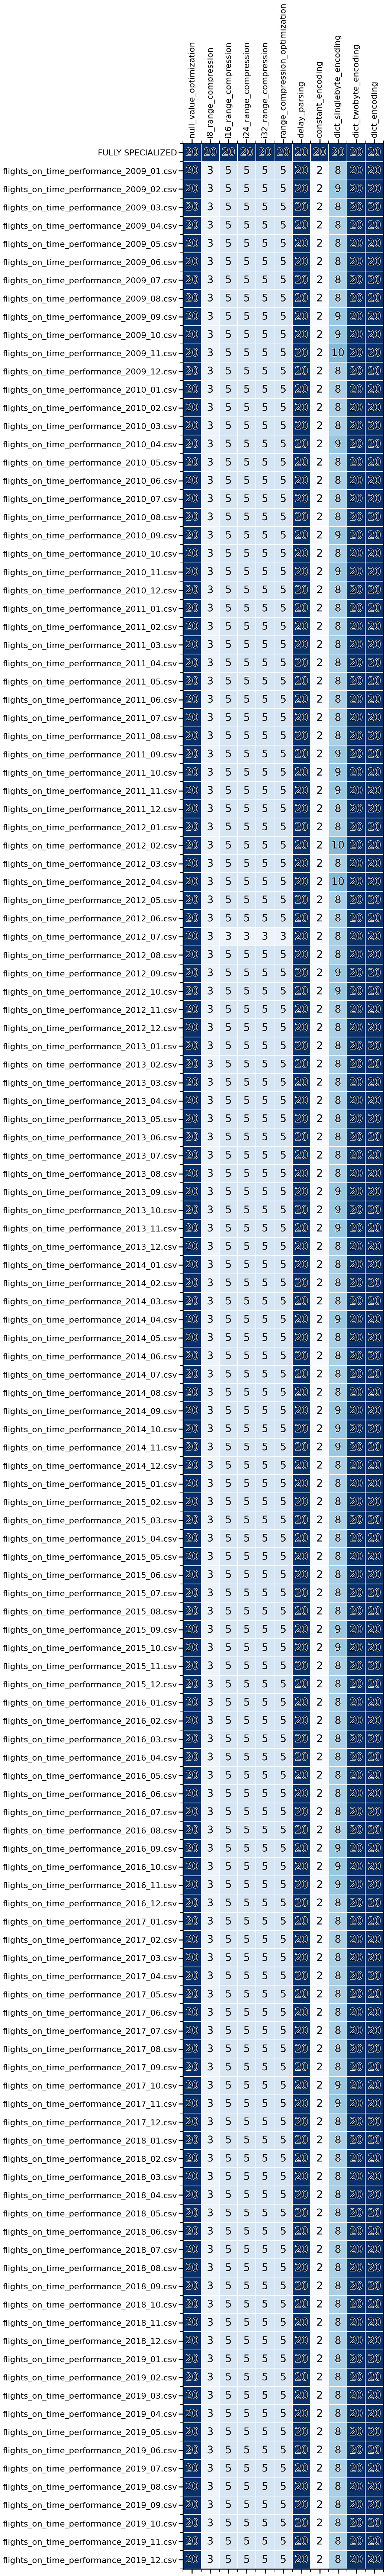

In [27]:
import copy
fig, ax = plt.subplots(figsize=(10, 120))

min_val, max_val = 0, len(df.columns)

cmap = copy.copy(plt.cm.get_cmap("Blues"))
cmap.set_bad('gray',1.)
ax.matshow(count_matrix, cmap=cmap)

for i in range(count_matrix.shape[1]):
    for j in range(count_matrix.shape[0]):
        c = count_matrix[j,i]
        if not math.isnan(c):
            txt = ax.text(i, j, str(int(c)), va='center', ha='center', fontsize=28)
            # cf. https://osxastrotricks.wordpress.com/2014/12/02/add-border-around-text-with-matplotlib/
            txt.set_path_effects([path_effects.Stroke(linewidth=2, foreground='white'),
                       path_effects.Normal()])
# ticks are names of files

ax = plt.gca();

# Major ticks
ax.set_xticks(np.arange(0, n_opts, 1))
ax.set_yticks(np.arange(0, n_names, 1))

# Labels for major ticks
# ax.set_xticklabels(np.arange(1, n_opts + 1, 1))
ax.set_xticklabels(optimization_list, rotation = 90)
# ax.set_yticklabels(np.arange(1, n_names + 1, 1))
ax.set_yticklabels(names)

# Minor ticks
ax.set_xticks(np.arange(-.5, n_opts, 1), minor=True)
ax.set_yticks(np.arange(-.5, n_names, 1), minor=True)

# Gridlines based on minor ticks
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

plt.savefig('flights_detailed_opts.png', dpi=120, transparent=True)

In [28]:
# what's the most frequent row/optimization counts?

In [29]:
count_matrix.shape

(133, 11)

In [30]:
count_matrix[1:, :].shape

(132, 11)

In [31]:
count_matrix.shape

(133, 11)

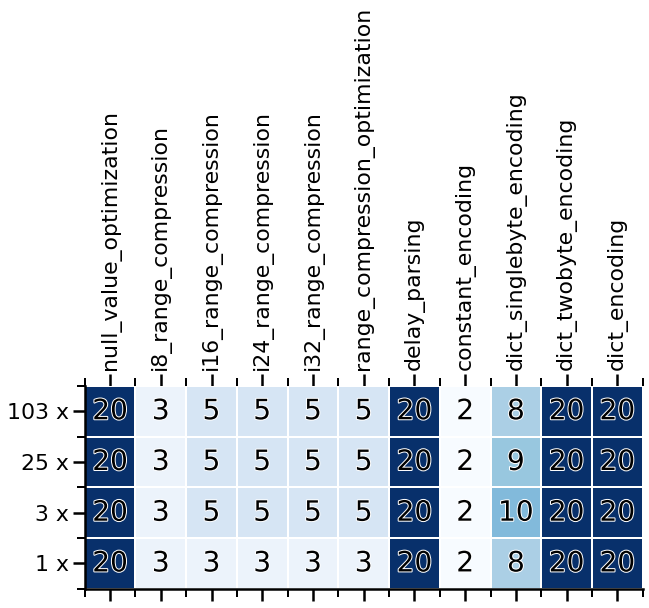

In [32]:
# get counts, drop the first row
unique_rows, counts = np.unique(count_matrix[1:, :], axis=0, return_counts=True)
unique_rows, counts

sort_idx = np.argsort(counts)[::-1]
counts = counts[sort_idx]
unique_rows = unique_rows[sort_idx, :]

# plot again out, this time with counts

fig, ax = plt.subplots(figsize=(10, 5))
min_val, max_val = 0, len(df.columns)

cmap = copy.copy(plt.cm.get_cmap("Blues"))
cmap.set_bad('gray',1.)
ax.matshow(unique_rows, cmap=cmap)

for i in range(unique_rows.shape[1]):
    for j in range(unique_rows.shape[0]):
        c = unique_rows[j,i]
        if not math.isnan(c):
            txt = ax.text(i, j, str(int(c)), va='center', ha='center', fontsize=28)
            # cf. https://osxastrotricks.wordpress.com/2014/12/02/add-border-around-text-with-matplotlib/
            txt.set_path_effects([path_effects.Stroke(linewidth=2, foreground='white'),
                       path_effects.Normal()])
# ticks are how often each combo occurs

combos = ['{} x'.format(c) for c in counts]
n_combos = len(combos)
ax = plt.gca();

# Major ticks
ax.set_xticks(np.arange(0, n_opts, 1))
ax.set_yticks(np.arange(0, n_combos, 1))

# Labels for major ticks
# ax.set_xticklabels(np.arange(1, n_opts + 1, 1))
ax.set_xticklabels(optimization_list, rotation = 90)
# ax.set_yticklabels(np.arange(1, n_names + 1, 1))
ax.set_yticklabels(combos)

# Minor ticks
ax.set_xticks(np.arange(-.5, n_opts, 1), minor=True)
ax.set_yticks(np.arange(-.5, n_combos, 1), minor=True)

# Gridlines based on minor ticks
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
sns.despine()

plt.savefig('flights_agg_opts.png', dpi=120, transparent=True)

Notes:
    
    
--> probabilistic checking approach? I.e., allow up to a certain number of rows to violate optimization constraint.
--> check older flight files
--> check github files.

In [98]:
# which variables can be dict encoded? which i8 range encoded?

As for the queries, only queries with Joins/Aggregates will benefit from it, because
the aggregation over narrowed types may be faster (vectorization!)
for joins, the buckets will be smaller & the amount of data to write out as intermediate is smaller.


Other effect for file -> file query is merely when data is passed "through", i.e. no data -> parse -> data cycle.


Main issue for hyperspecialization workload: Need to find dataset where data between individual buckets varies significantly! I.e., by reordering data or so!

Test, what about if data is repartitioned by other variable than year?

=> partition after carrier!

To repartition, run following in Spark shell
```
val df= spark.read.option("header", "true").csv("/hot/data/flights/flights_on_time_performance_*.csv")
import spark.implicits._
df.repartition($"OP_CARRIER_AIRLINE_ID").write.mode("overwrite").partitionBy("OP_CARRIER_AIRLINE_ID").format("csv").option("header", "true").save("/hot/scratch/hyperspecialization/partitioned_flights")
```

In [36]:
!ls /hot/scratch/hyperspecialization/partitioned_flights/'OP_CARRIER_AIRLINE_ID=19386' 

part-00140-8642845d-959f-4e50-902d-6f87d4826a6f.c000.csv


run the above code again, to detect what's going on

In [37]:
paths = glob.glob('/hot/scratch/hyperspecialization/partitioned_flights/*/*.csv')
len(paths)

24

In [38]:
start = time.time()
results = Parallel(n_jobs=32, verbose=10)(
    delayed(detect_file_specific_optimizations)(path, relevant_indices) for path in paths)
stop = time.time()

print('Elapsed time for the entire processing: {:.2f} s'
      .format(stop - start))

[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   1 tasks      | elapsed:    9.3s
[Parallel(n_jobs=32)]: Done   3 out of  24 | elapsed:   13.9s remaining:  1.6min
[Parallel(n_jobs=32)]: Done   6 out of  24 | elapsed:   28.8s remaining:  1.4min
[Parallel(n_jobs=32)]: Done   9 out of  24 | elapsed:   35.5s remaining:   59.1s
[Parallel(n_jobs=32)]: Done  12 out of  24 | elapsed:   52.7s remaining:   52.7s
[Parallel(n_jobs=32)]: Done  15 out of  24 | elapsed:  1.4min remaining:   50.5s
[Parallel(n_jobs=32)]: Done  18 out of  24 | elapsed:  2.6min remaining:   51.3s
[Parallel(n_jobs=32)]: Done  21 out of  24 | elapsed:  5.5min remaining:   47.2s


Elapsed time for the entire processing: 586.69 s


[Parallel(n_jobs=32)]: Done  24 out of  24 | elapsed:  9.8min remaining:    0.0s
[Parallel(n_jobs=32)]: Done  24 out of  24 | elapsed:  9.8min finished


In [39]:
df_opt = pd.DataFrame(results)
df_opt = df_opt.sort_values(by='path').reset_index(drop=True)
df_opt.head()

,null_value_optimization,i8_range_compression,i16_range_compression,i24_range_compression,i32_range_compression,range_compression_optimization,delay_parsing,dict_singlebyte_encoding,dict_twobyte_encoding,dict_encoding,path,ncolumns,details
0,20,4,5,5,5,5,20,8,20,20,/hot/scratch/hyperspecialization/partitioned_f...,20,"{'2009': {'type': 'int64', 'nullable': True, '..."
1,20,4,4,4,4,4,20,9,20,20,/hot/scratch/hyperspecialization/partitioned_f...,20,"{'2009': {'type': 'int64', 'nullable': True, '..."
2,20,4,5,5,5,5,20,10,20,20,/hot/scratch/hyperspecialization/partitioned_f...,20,"{'2009': {'type': 'int64', 'nullable': True, '..."
3,20,4,5,5,5,5,20,7,20,20,/hot/scratch/hyperspecialization/partitioned_f...,20,"{'2009': {'type': 'int64', 'nullable': True, '..."
4,20,4,5,5,5,5,20,7,20,20,/hot/scratch/hyperspecialization/partitioned_f...,20,"{'2009': {'type': 'int64', 'nullable': True, '..."


In [40]:
name = df_opt.iloc[0].path

def normalize_name(path):
    return path[path.find('flights/')+len('flights/'):path.rfind('/')]
normalize_name(name)

'OP_CARRIER_AIRLINE_ID=19386'

In [41]:
# plot how many files could have optimizations!
names = ['FULLY SPECIALIZED'] + list(df_opt.path.apply(normalize_name).values)
n_names = len(names)

n_opts = len(optimization_list)

count_matrix = np.zeros((n_names, n_opts)) * np.nan
n_columns = df_opt.iloc[0]['ncolumns']


# fill in first row with ncolumns
count_matrix[0, :] = n_columns

# fill in from rows
for idx, row in df_opt.iterrows():
    row = row.to_dict()
    for key, value in row.items():
        if key in optimization_list:
            j = optimization_list.index(key)
            count_matrix[idx + 1, j] = value
count_matrix.shape

(25, 9)

In [42]:
# do again the specialization plot

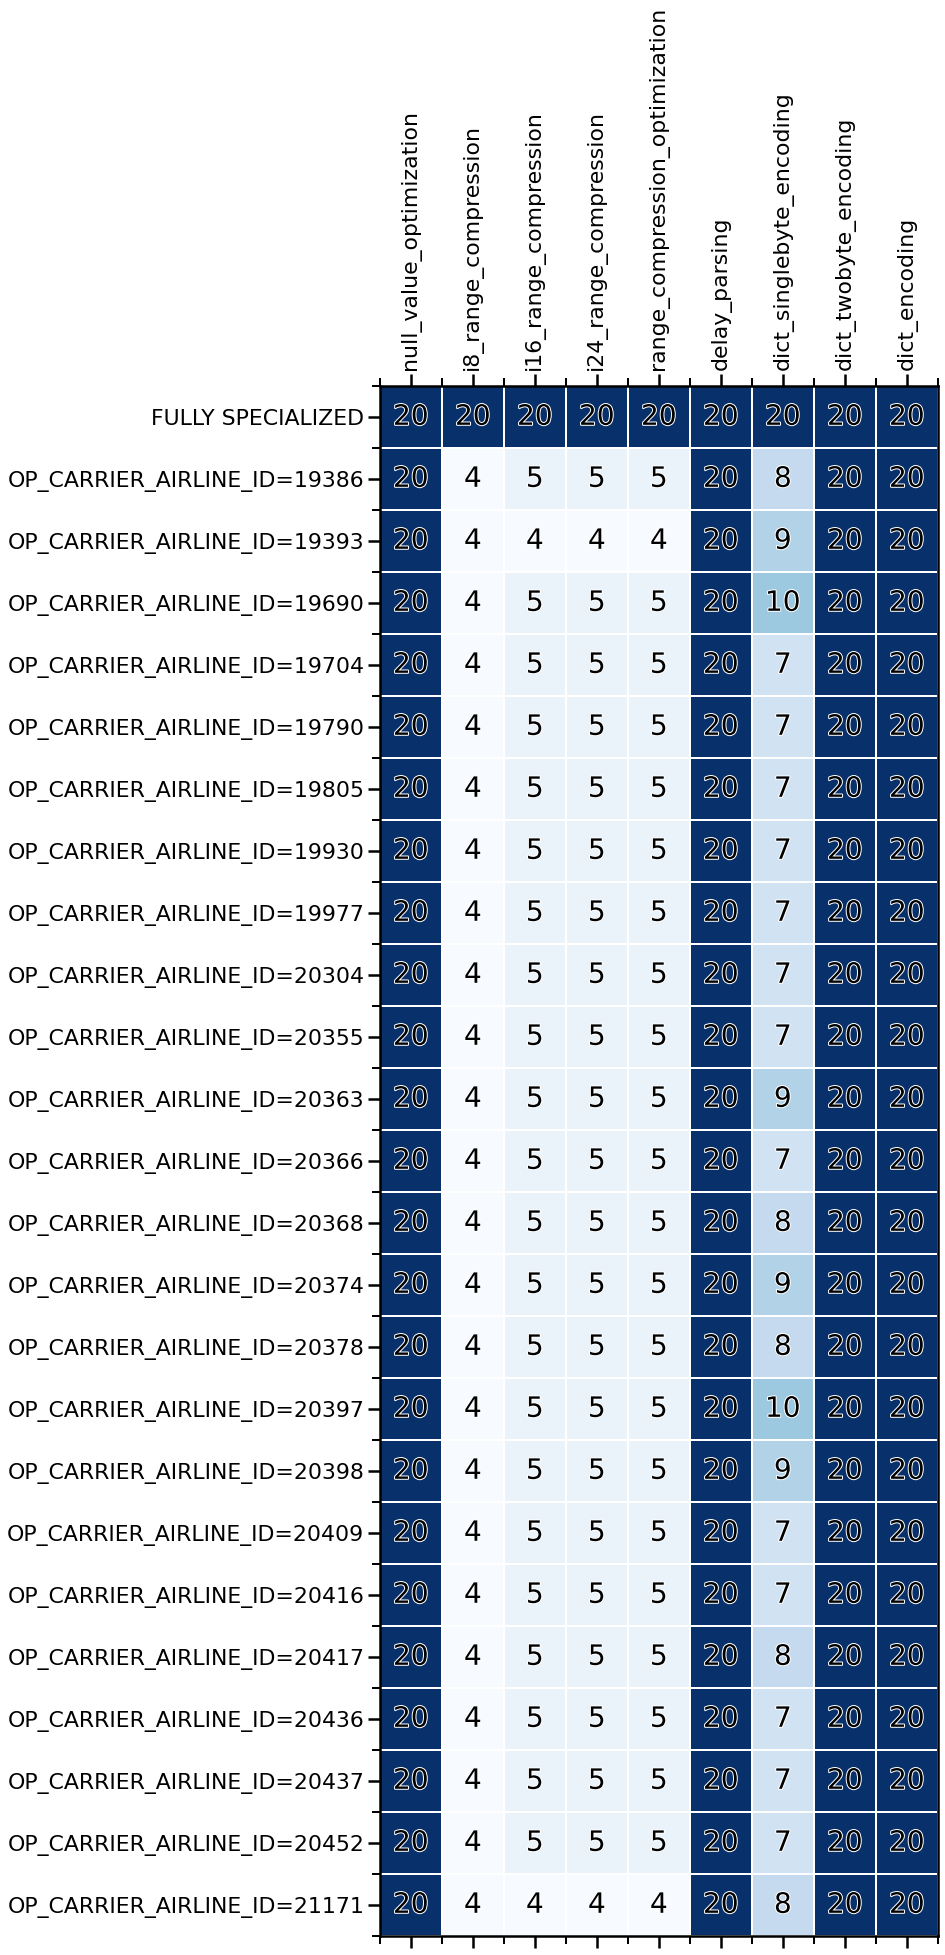

In [43]:
import copy
fig, ax = plt.subplots(figsize=(10, 120))

min_val, max_val = 0, len(df.columns)

cmap = copy.copy(plt.cm.get_cmap("Blues"))
cmap.set_bad('gray',1.)
ax.matshow(count_matrix, cmap=cmap)

for i in range(count_matrix.shape[1]):
    for j in range(count_matrix.shape[0]):
        c = count_matrix[j,i]
        if not math.isnan(c):
            txt = ax.text(i, j, str(int(c)), va='center', ha='center', fontsize=28)
            # cf. https://osxastrotricks.wordpress.com/2014/12/02/add-border-around-text-with-matplotlib/
            txt.set_path_effects([path_effects.Stroke(linewidth=2, foreground='white'),
                       path_effects.Normal()])
# ticks are names of files

ax = plt.gca();

# Major ticks
ax.set_xticks(np.arange(0, n_opts, 1))
ax.set_yticks(np.arange(0, n_names, 1))

# Labels for major ticks
# ax.set_xticklabels(np.arange(1, n_opts + 1, 1))
ax.set_xticklabels(optimization_list, rotation = 90)
# ax.set_yticklabels(np.arange(1, n_names + 1, 1))
ax.set_yticklabels(names)

# Minor ticks
ax.set_xticks(np.arange(-.5, n_opts, 1), minor=True)
ax.set_yticks(np.arange(-.5, n_names, 1), minor=True)

# Gridlines based on minor ticks
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

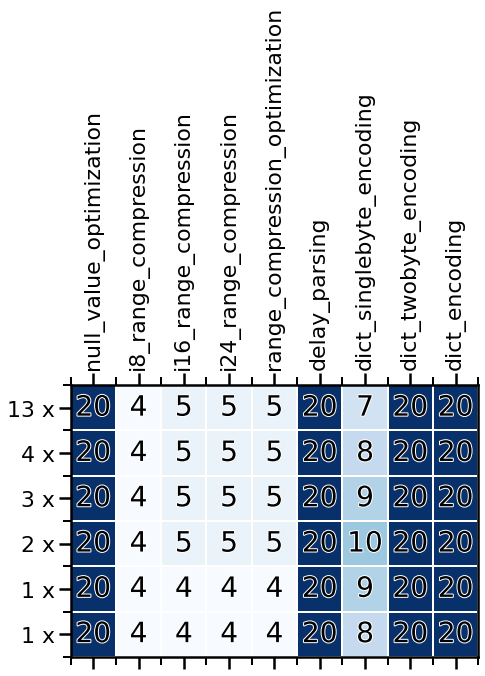

In [44]:
# get counts, drop the first row
unique_rows, counts = np.unique(count_matrix[1:, :], axis=0, return_counts=True)
unique_rows, counts

sort_idx = np.argsort(counts)[::-1]
counts = counts[sort_idx]
unique_rows = unique_rows[sort_idx, :]

# plot again out, this time with counts

fig, ax = plt.subplots(figsize=(10, 5))
min_val, max_val = 0, len(df.columns)

cmap = copy.copy(plt.cm.get_cmap("Blues"))
cmap.set_bad('gray',1.)
ax.matshow(unique_rows, cmap=cmap)

for i in range(unique_rows.shape[1]):
    for j in range(unique_rows.shape[0]):
        c = unique_rows[j,i]
        if not math.isnan(c):
            txt = ax.text(i, j, str(int(c)), va='center', ha='center', fontsize=28)
            # cf. https://osxastrotricks.wordpress.com/2014/12/02/add-border-around-text-with-matplotlib/
            txt.set_path_effects([path_effects.Stroke(linewidth=2, foreground='white'),
                       path_effects.Normal()])
# ticks are how often each combo occurs

combos = ['{} x'.format(c) for c in counts]
n_combos = len(combos)
ax = plt.gca();

# Major ticks
ax.set_xticks(np.arange(0, n_opts, 1))
ax.set_yticks(np.arange(0, n_combos, 1))

# Labels for major ticks
# ax.set_xticklabels(np.arange(1, n_opts + 1, 1))
ax.set_xticklabels(optimization_list, rotation = 90)
# ax.set_yticklabels(np.arange(1, n_names + 1, 1))
ax.set_yticklabels(combos)

# Minor ticks
ax.set_xticks(np.arange(-.5, n_opts, 1), minor=True)
ax.set_yticks(np.arange(-.5, n_combos, 1), minor=True)

# Gridlines based on minor ticks
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

I.e. trick here could be to use some aggregateByKey statistic (vectorized!) where the aggByKey is one of the columns where dcy_singlebyte_encoding changes. If we're lucky it's a meaningful column!

Note: This tool above can be also used quite well to determine the specialization potential for some partitioned
      dataset.
      I.e., investigate maybe original 311 requests etc.

Note:

The above is not really helpful. What we really want is already select the best optimization/encoding for each column!

==> That's an optimizer problem.

We also need to know how much effect it has to have certain combos.


Need to craft queries where this matters...



Note: For Github/JSON dataset this analysis might be even more helpful. I.e., flatten out JSON doc!

In [45]:
df_opt.to_csv('flights_repartitioned_optimizations.csv', index=None)

In [ ]:
path = '/hot/data/311/311_2010_to_2020.csv'
ans = detect_file_specific_optimizations(path)

In [ ]:
ans

In [46]:

path = '/hot/data/flights/flights_on_time_performance_2019_12.csv'

df = pd.read_csv(path, usecols=relevant_indices, low_memory=False)
df_str = pd.read_csv(path, dtype=str, usecols=relevant_indices, low_memory=False)

df_stats = get_stats(df, df_str)
df_stats['optimizations'] = df_stats.apply(functools.partial(determine_col_optimizations), axis=1)

# for each column count how many of each optimizations are available
df_this_file_opt = pd.DataFrame(list(df_stats['optimizations'].values))
row = df_this_file_opt.sum().to_dict()
row['path'] = path
row['ncolumns'] = len(df.columns)

In [47]:
details

NameError: name 'details' is not defined

In [ ]:
df.columns

In [ ]:
masked_array = np.ma.array (a, mask=np.isnan(a))
cmap = matplotlib.cm.jet
cmap.set_bad('white',1.)
ax.imshow(masked_array, interpolation='nearest', cmap=cmap)

In [ ]:
fig, ax = plt.subplots()

min_val, max_val = 0, 15

intersection_matrix = np.random.randint(0, 10, size=(max_val, max_val))

ax.matshow(intersection_matrix, cmap=plt.cm.Blues)

for i in range(15):
    for j in range(15):
        c = intersection_matrix[j,i]
        ax.text(i, j, str(c), va='center', ha='center')

In [ ]:
# filter specialization for each file!!!

# could write benchmark with two numbers -> parse, then specialize!